In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
import sys
import torch
import h5py
import glob
import random

from helpers.utils import make_dir_safely

# Import models
from models.vae import VAE, VAE_convT, VAE_linear
sys.path.append('/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/helpers')
from batches import plot_batch_3d_complete, plot_batch_3d_complete_1_chan 


# Download the methods for generating synthetic data
from helpers.synthetic_anomalies import generate_noise, create_cube_mask,\
                         generate_deformation_chan, create_hollow_noise



# For the patch blending we import from another directory
sys.path.append('/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/git_repos/many-tasks-make-light-work')
from multitask_method.tasks.patch_blending_task import TestPatchInterpolationBlender, \
    TestPoissonImageEditingMixedGradBlender, TestPoissonImageEditingSourceGradBlender

from multitask_method.tasks.labelling import FlippedGaussianLabeller


labeller = FlippedGaussianLabeller(0.2)

from helpers.visualization import plot_batches_SSL

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Load the data
data_dir = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/data'
data_vl = h5py.File(os.path.join(data_dir, 'masked_slice_anomalies_images_from_35_to_42.hdf5'), 'r')
images_vl  = data_vl['images']
labels_vl = data_vl['masks']

# Load the two healthy subjects not seen during training/validation
data_vl_unseen = h5py.File(os.path.join(data_dir, 'val_masked_sliced_images_from_42_to_44.hdf5'), 'r')
images_vl_unseen = data_vl_unseen['sliced_images_val']
images_vl.shape, labels_vl.shape, images_vl_unseen.shape

cpu


/scratch_net/biwidl203/lschlyter/anaconda3/envs/vtk_wrap/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


((3136, 32, 32, 24, 4), (3136, 32, 32, 24, 4), (128, 32, 32, 24, 4))

In [79]:
# Find the best model
models_dir = "/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/logs"
#model_rel_path = "vae/masked_slice/20230620-1105_vae_masked_slice_SSL_lr1.000e-03_scheduler-e600-bs8-gf_dim8-daFalse"
#model_rel_path = "vae_convT/masked_slice/20230620-1427_vae_convT_interpolation_val_masked_slice_SSL_lr5.000e-03_scheduler-e150-bs8-gf_dim8-daFalse"
#model_rel_path = "vae_convT/masked_slice/20230619-1947_vae_convT_masked_slice_SSL_lr1.000e-03-e350-bs8-gf_dim8-daFalse"
model_rel_path = "vae_convT/masked_slice/20230620-1420_vae_convT_interpolation_val_masked_slice_SSL_lr5.000e-03-e150-bs8-gf_dim8-daFalse"
model_path = os.path.join(models_dir, model_rel_path)
pattern = os.path.join(model_path, '*best*')
matching_files = glob.glob(pattern)
best_model_path = matching_files[0]

print(best_model_path)



model = model_rel_path.split('/')[0]
preprocess_method = model_rel_path.split('/')[1]
model_name = model_rel_path.split('/')[-1]

results_dir_val = 'Results/Evaluation/' + model + '/' + preprocess_method + '/' + model_name + '/' + 'validation'
results_dir_val_unseen = 'Results/Evaluation/' + model + '/' + preprocess_method + '/' + model_name + '/' + 'validation_unseen'
make_dir_safely(results_dir_val)
make_dir_safely(results_dir_val_unseen)

# Load the model
if model == 'vae':
    model = VAE(in_channels=4, out_channels=1, gf_dim=8).to(device)
elif model == 'vae_convT':
    model = VAE_convT(in_channels=4, out_channels=1, gf_dim=8).to(device)


model.load_state_dict(torch.load(best_model_path, map_location=device))

/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/logs/vae_convT/masked_slice/20230620-1420_vae_convT_interpolation_val_masked_slice_SSL_lr5.000e-03-e150-bs8-gf_dim8-daFalse/20230620-1420_vae_convT_interpolation_val_masked_slice_SSL_lr5.000e-03-e150-bs8-gf_dim8-daFalse.ckpt-best


<All keys matched successfully>

In [80]:
same_indices = True
if same_indices:
    random.seed(1)
n_indices = 320
indices = random.sample(range(len(images_vl) ), n_indices)
indices = np.sort(indices)

In [81]:
input_images_vl = torch.from_numpy(images_vl[indices]).transpose(1,4).transpose(2,4).transpose(3,4).to(device)
input_labels_vl = torch.from_numpy(labels_vl[indices]).transpose(1,4).transpose(2,4).transpose(3,4).to(device)

batch_size = 32
input_images_vl.shape, input_labels_vl.shape

(torch.Size([320, 4, 32, 32, 24]), torch.Size([320, 4, 32, 32, 24]))

In [82]:
deformation_list = ['None', 'noisy', 'deformation', 'hollow_circle', 'patch_interpolation', 'poisson_with_mixing', 'poisson_without_mixing']
noise_generator = generate_noise(batch_size = batch_size,mean_range = (0, 0.1), std_range = (0, 0.2), n_samples= images_vl_unseen.shape[0])

In [83]:
def apply_deformation(def_function, all_images, batch, mask_blending):
    random_indices = random.sample(range(len(all_images)), batch_size)
    random_indices = np.sort(random_indices)
    images_for_blending = all_images[random_indices]
    batch = np.transpose(batch, (0,4,1,2,3))
    images_for_blending = np.transpose(images_for_blending, (0,4,1,2,3))
    
    blended_images = []
    anomaly_masks = []
    for input_, blender in zip(batch, images_for_blending):
        
        blending_function = def_function(labeller, blender, mask_blending)
        blended_image, anomaly_mask = blending_function(input_, mask_blending)
        # Expand dims to add batch dimension
        blended_image = np.expand_dims(blended_image, axis=0)
        anomaly_mask = np.expand_dims(anomaly_mask, axis=0)
        blended_images.append(blended_image)
        anomaly_masks.append(anomaly_mask)
    batch = np.concatenate(blended_images, axis = 0)    
    labels = np.concatenate(anomaly_masks, axis = 0)
    batch = np.transpose(batch, (0,2,3,4,1))
    labels = np.expand_dims(labels, axis = -1)
    return batch, labels

In [84]:
def debug():    
    start_idx = 0
    end_idx = batch_size
    mask_shape = [32, 32, 24]
    mask_blending = create_cube_mask(mask_shape, WH= 20, depth= 12,  inside=True).astype(np.bool_)
    for deformation in deformation_list:
        print(deformation)
        while end_idx <= images_vl_unseen.shape[0]:
            
            batch = images_vl_unseen[start_idx:end_idx]
            
            if deformation == 'None':
                labels = np.zeros(batch.shape)

            elif deformation == 'noisy':
                mean, std, noise = next(noise_generator)
                noise = noise/[10,1,1,1]
                batch = batch + noise
                labels = noise

            elif deformation == 'deformation':
                batch, labels = generate_deformation_chan(batch)

            elif deformation == 'hollow_circle':
                labels = create_hollow_noise(batch, mean=mean, std=std)
                
                batch = batch + labels
            elif deformation == 'patch_interpolation':
                batch, labels = apply_deformation(TestPatchInterpolationBlender, images_vl_unseen, batch, mask_blending)
            elif deformation == 'poisson_with_mixing':
                batch, labels = apply_deformation(TestPoissonImageEditingMixedGradBlender, images_vl_unseen, batch, mask_blending)
            elif deformation == 'poisson_without_mixing':
                batch, labels = apply_deformation(TestPoissonImageEditingSourceGradBlender, images_vl_unseen, batch, mask_blending)
                
            else:
                raise NotImplementedError
            
            if labels.shape[-1] == 1:
                labels = np.repeat(labels, 4, axis=-1)
            batch = torch.from_numpy(batch).transpose(1,4).transpose(2,4).transpose(3,4).float().to(device)

            with torch.no_grad():
                output_dict = model(batch)
                output_images = torch.sigmoid(output_dict['decoder_output'])
            output_images = output_images.transpose(1,2).transpose(2,3).transpose(3,4).cpu().detach().numpy()
            labels = labels#.transpose(1,2).transpose(2,3).transpose(3,4).cpu().detach().numpy()
            batch = batch.transpose(1,2).transpose(2,3).transpose(3,4).cpu().detach().numpy()
            channel_to_show = 1
            plot_batches_SSL(batch, output_images, labels, channel_to_show = channel_to_show, every_x_time_step=1, out_path=os.path.join(results_dir_val_unseen, 'batch_{}_to_{}_{}_c_{}.png'.format(start_idx, end_idx, deformation, channel_to_show)))
            start_idx += batch_size
            end_idx += batch_size
        start_idx = 0
        end_idx = batch_size

debug()

None
noisy
deformation
hollow_circle
patch_interpolation
poisson_with_mixing
poisson_without_mixing


In [2]:

healthy_rmse = [0.019191295257769525, 0.01684183336328715, 0.015168259968049824, 0.014168259968049824, 0.0150]

unhealthy_rmse= [0.191295257769525,0.02541162414642969, 0.04234149342774374,0.03541162414642969, 0.041, 0.0140]


In [3]:
scores = np.concatenate([unhealthy_rmse, healthy_rmse])
labels = np.concatenate([np.ones(len(unhealthy_rmse)), np.zeros(len(healthy_rmse))])


In [4]:
fpr, tpr, thresholds = roc_curve(labels, scores)


In [5]:
auc_score = auc(fpr, tpr)

auc_score

0.8333333333333334

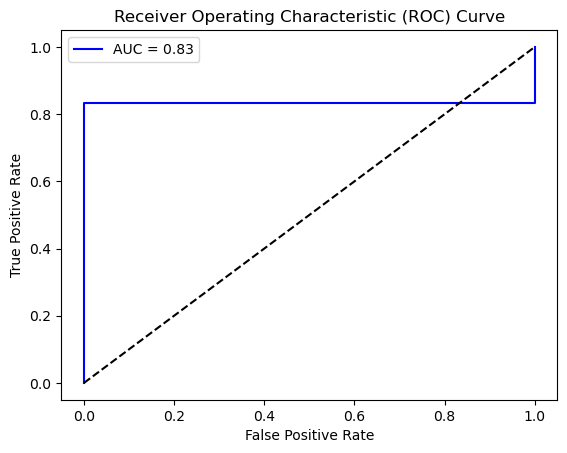

In [6]:
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
